In [1]:
import torch

In [130]:
# sample from a normal distribution mean 0, std 1
distribution = torch.distributions.Normal(1, 0.2)
distribution.sample()

tensor(1.3885)

In [139]:
# bayesian update of the distribution
distribution = torch.distributions.Normal(1, 0.2)
distribution = torch.distributions.Normal(distribution.mean, distribution.stddev + 0.1)
distribution.sample()

tensor(1.4310)

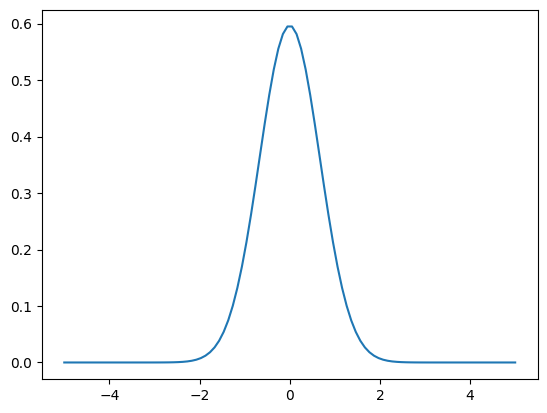

In [79]:
# plot normal distribution
import matplotlib.pyplot as plt
import numpy as np

s2 = np.sqrt(0.2)
x = np.linspace(-5, 5, 100)
y = 1/np.sqrt(2*np.pi*s2) * np.exp(-x**2/(2*s2))
plt.plot(x, y)
